In [19]:
%matplotlib inline
%run '../bin/notebook_utils.py'
import matplotlib.ticker as mticker

In [20]:
# Frontera, default MPI
sscaling1_sessions = pd.read_csv('../data/spatial-heterogeneity/sessions.csv', index_col=0)

In [21]:
print('Strong scaling 1: Total number of successful runs: %s' % sscaling1_sessions.shape[0])

Strong scaling 1: Total number of successful runs: 3


In [22]:
sscaling1_sessions['nnode'] = sscaling1_sessions.ncore/56
sscaling1_sessions['list'] = sscaling1_sessions[['nunit', 'nnode']].astype(
    int, errors='ignore').astype('str').values.tolist()
sscaling1_sessions['nunitnode'] = sscaling1_sessions['list'].apply('/'.join)

sscaling1_ws = sscaling1_sessions[['nunit', 'nunitnode', 'TTC', 'P_LRMS_QUEUING', 'U_AGENT_QUEUING',
                         'U_AGENT_SCHEDULING', 'U_AGENT_QUEUING_EXEC', 'U_AGENT_EXECUTING',
                         'cu_exec_start_stop', 'nunit_failed', 'util_p_total']
                        ].groupby(['nunit', 'nunitnode']).aggregate(
    {'TTC': ['mean', 'std'],
     'P_LRMS_QUEUING': ['mean', 'std'],
     'U_AGENT_QUEUING': ['mean', 'std'],
     'U_AGENT_SCHEDULING': ['mean', 'std'],
     'U_AGENT_QUEUING_EXEC': ['mean', 'std'],
     'U_AGENT_EXECUTING': ['mean', 'std'],
     'cu_exec_start_stop': ['mean', 'std'],
     'util_p_total': ['mean', 'std'],
     'nunit_failed': ['mean']
     })

sscaling1_ws.rename({'P_LRMS_QUEUING': 'TTQ'}, axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_QUEUING': 'Agent queueing'},
               axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_SCHEDULING': 'Agent scheduling'},
               axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_QUEUING_EXEC': 'Agent queueing execution'},
               axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_EXECUTING': 'TTX Agent'},
               axis='columns', inplace=True)
sscaling1_ws.rename({'cu_exec_start_stop': 'TTX Unit'},
               axis='columns', inplace=True)
sscaling1_ws.rename({'util_p_total': 'TTX'}, axis='columns', inplace=True)

sscaling1_ws = sscaling1_ws.sort_values("nunit")
sscaling1_ws

TTC               TTQ     Agent queueing     Agent scheduling     Agent queueing execution        TTX Agent         TTX Unit            TTX     nunit_failed
                         mean std          mean std           mean std             mean std                     mean std         mean std         mean std       mean std         mean
nunit nunitnode                                                                                                                                                                       
8192  8192/128   1.582876e+09 NaN  19270.812658 NaN      73.802099 NaN       224.673061 NaN               137.225675 NaN   237.257034 NaN   236.996802 NaN   302.5836 NaN         1024
      8192/4     1.582614e+09 NaN  50568.295706 NaN       0.000000 NaN      4189.375814 NaN                72.615880 NaN  7250.081748 NaN  7249.807499 NaN  7306.5206 NaN            0
      8192/64    1.582859e+09 NaN   2477.936230 NaN      84.736933 NaN       476.837729 NaN               167.517691 NaN   490.019885 NaN   489.629600 NaN   572.3813 NaN            0

In [23]:
# Total agent time = 
#    ru.STATE: rp.AGENT_SCHEDULING             - ru.STATE: rp.AGENT_SCHEDULING_PENDING +
#    ru.STATE: rp.AGENT_EXECUTING_PENDING      - ru.STATE: rp.AGENT_SCHEDULING         +
#    ru.STATE: rp.AGENT_EXECUTING              - ru.STATE: rp.AGENT_EXECUTING_PENDING  +
#    ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING - ru.STATE: rp.AGENT_EXECUTING          -
#    ru.EVENT: 'cu_exec_stop'                  - ru.EVENT: 'cu_exec_start'
#
# Total task execution time = 900 (derived analytically from the time passed to stress)

oh1 = sscaling1_ws.copy(deep=True)
oh1.loc[:,('TTX Agent','mean')] = (oh1.loc[:,('Agent queueing','mean')]            + \
                                   oh1.loc[:,('Agent scheduling','mean')]          + \
                                   oh1.loc[:,('Agent queueing execution','mean')]) + \
                                  (oh1.loc[:,('TTX Agent','mean')]                 - \
                                   oh1.loc[:,('TTX Unit','mean')])
# oh1.loc[:,('TTX Unit','mean')]  = oh1.loc[:,('TTX Unit','mean')] - 900
# oh1.loc[:,('nunit_failed','mean')] = oh1.loc[:,('nunit_failed','mean')].apply(np.ceil)

oh1.columns = [' '.join(col).strip() for col in oh1.columns.values]

oh1 = oh1.sort_values("nunit")
oh1 = oh1.reset_index()
oh1

,nunit,nunitnode,TTC mean,TTC std,TTQ mean,TTQ std,Agent queueing mean,Agent queueing std,Agent scheduling mean,Agent scheduling std,Agent queueing execution mean,Agent queueing execution std,TTX Agent mean,TTX Agent std,TTX Unit mean,TTX Unit std,TTX mean,TTX std,nunit_failed mean
0,8192,8192/128,1.582876e+09,NaN,19270.812658,NaN,73.802099,NaN,224.673061,NaN,137.225675,NaN,435.961066,NaN,236.996802,NaN,302.5836,NaN,1024
1,8192,8192/4,1.582614e+09,NaN,50568.295706,NaN,0.000000,NaN,4189.375814,NaN,72.615880,NaN,4262.265943,NaN,7249.807499,NaN,7306.5206,NaN,0
2,8192,8192/64,1.582859e+09,NaN,2477.936230,NaN,84.736933,NaN,476.837729,NaN,167.517691,NaN,729.482639,NaN,489.629600,NaN,572.3813,NaN,0


In [24]:
# Total agent time = 'util_p_total'
# ru.EVENT: 'bootstrap_0_stop' - ru.EVENT: 'bootstrap_0_start'

ttc1 = sscaling1_ws[['TTX']]
ttc1.columns = [' '.join(col).strip() for col in ttc1.columns.values]
ttc1 = ttc1.sort_values("nunit")
ttc1 = ttc1.reset_index()

ttc1


,nunit,nunitnode,TTX mean,TTX std
0,8192,8192/128,302.5836,NaN
1,8192,8192/4,7306.5206,NaN
2,8192,8192/64,572.3813,NaN


/Users/mturilli/Virtualenvs/rp-paper-frontera/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


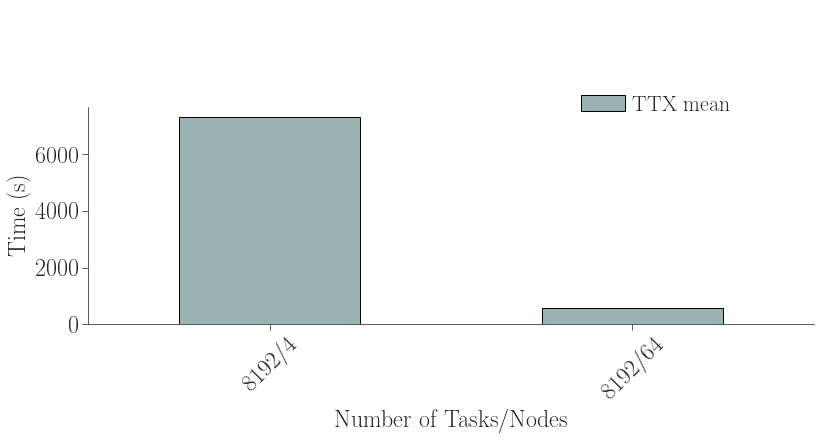

In [46]:
fig, ax = fig_setup(figsize=(13,4))

ax1 = ttc1.loc[1:10].plot.bar(
    x='nunitnode', 
    y='TTX mean', 
#     yerr='TTX std', 
    width=0.5, color=tableau20[22], 
#     logy=True,
    ax=ax, rot=45,
    legend=False)

# ax1.axhline(y=900, lw=1.5, color='black', ls='dashed')

ax.set_xlabel('Number of Tasks/Nodes')
ax.set_ylabel('Time (s)')
# ax.set_ylim(0)
# ax.set_xlim(-0.5)

fig.legend(  # (mpl.patches.Patch(facecolor=tableau20[1]), 
             #  mpl.patches.Patch(facecolor=tableau20[20]), 
             #  mpl.lines.Line2D([], [], color='black', linestyle='dashed')), 
             # ('TTX JSRUN mean', 'Ideal TTX'),
             # ncol=2,
             # columnspacing=0.75,
            (mpl.patches.Patch(facecolor=tableau20[22]), None),
            ('TTX mean', ' '), 
            'upper left',
            handletextpad=0.3,
            bbox_to_anchor=(0.6, 1.265))

plt.savefig('figures/strong_scaling_ttc.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/strong_scaling_ttc.png', dpi=300, bbox_inches='tight')

In [4]:
# sessions sscaling1
# sscaling1_sids = sorted(['../data/spatial-heterogeneity/sscaling1/'+s for s in sscaling1_sessions.drop_duplicates(['nunit']).index.unique().tolist()])
# sscaling1_sobjs = ra.Experiment(sscaling1_sids, stype='radical.pilot')
sscaling1_sobjs = ra.Experiment(['../data/spatial-heterogeneity/sscaling1/rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0001'], stype='radical.pilot')

In [5]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Execution', ['exec_queue', 'exec_prep']],
        ['Execution RP',      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Execution Cmd',     ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [6]:
# choose the metrics we want to use for resource utilization
metrics = metrics_default

# get utilization information
provided_sscaling1, consumed_sscaling1, stats_abs_sscaling1, stats_rel_sscaling1, info_sscaling1 = sscaling1_sobjs.utilization(metrics=metrics)


In [7]:
# x-axis labels
xkeys_sscaling1 = list()

# get the numbers we actually want to plot
for session in sscaling1_sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys_sscaling1.append('%s / %s' % (n_units, p_size))

In [8]:
def update_ticks(x, pos):
    return int(x/4)

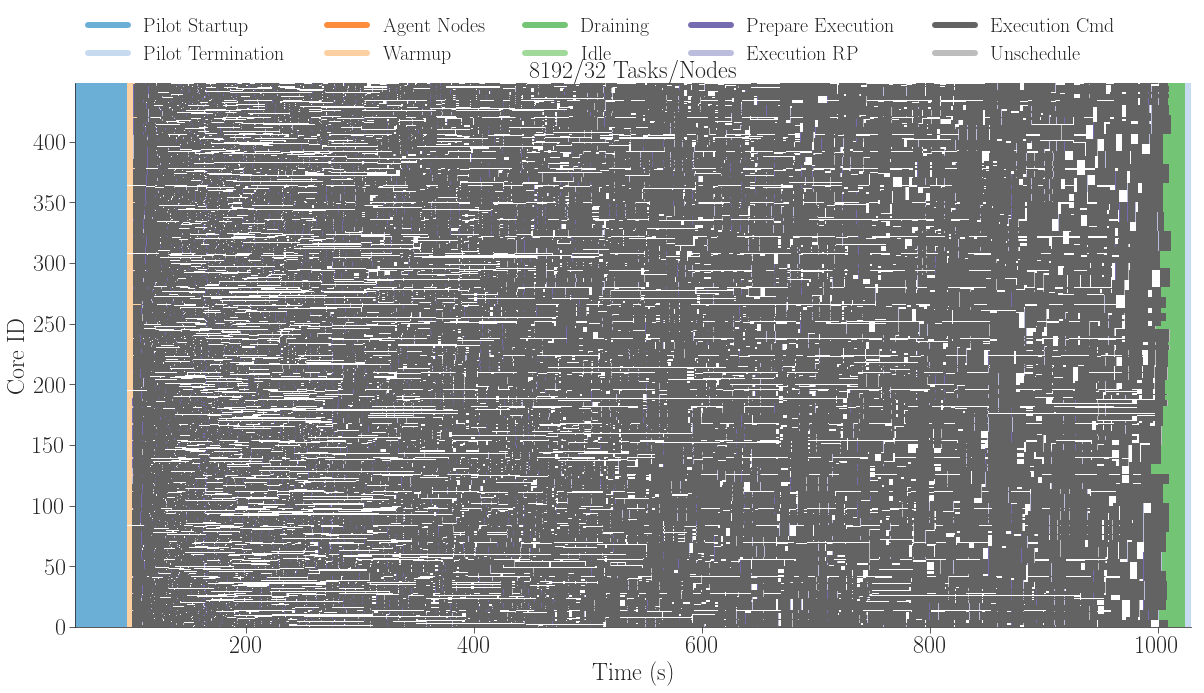

In [13]:
# core utilization over time (box plot)
sid = 'rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0001' # 8192 units| 2 nodes
consumed = consumed_sscaling1

fig, ax = fig_setup(figsize=(20,10))

cmap = mpl.cm.get_cmap('tab20c')

step = 1.0 / (len(metrics) + 1)
this = step / 1.0
legend = list()

x_min = None
x_max = None
y_min = None
y_max = None

ax.title.set_text('%s/%s Tasks/Nodes' % ('8192','32'))#(sscaling_sessions.loc[sid].nunit, int(sscaling_sessions.loc[sid].nnode)))

for metric in metrics:

    color = cmap(this)
    this += step

    legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

    if isinstance(metric, list):
        name = metric[0]
        parts = metric[1]
    else:
        name = metric
        parts = [metric]

    for part in parts:
        for uid in consumed[sid][part]:
            for block in consumed[sid][part][uid]:
                orig_x = block[0]
                orig_y = block[2] - 0.5
                width = block[1] - block[0]
                height = block[3] - block[2] + 1.0

                if x_min is None:
                    x_min = orig_x
                if x_max is None:
                    x_max = orig_x + width
                if y_min is None:
                    y_min = orig_x
                if y_max is None:
                    y_max = orig_x + height

                x_min = min(x_min, orig_x)
                y_min = min(y_min, orig_y)
                x_max = max(x_max, orig_x + width)
                y_max = max(y_max, orig_y + height)

                patch = mpl.patches.Rectangle((orig_x, orig_y),
                                              width, height,
                                              facecolor=color,
                                              edgecolor='black',
                                              fill=True, lw=0.0)
                ax.add_patch(patch)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Core ID')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

# Add legend
lgd = fig.legend(legend, 
       [m[0] for m in metrics], 
       loc='upper center', 
       # bbox_to_anchor=(0.5, 1.03),
       fontsize=20,
       ncol=5)

plt.savefig('figures/paper_rp_frontera_strong_scaling_heterogeneous.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_rp_frontera_strong_scaling_heterogeneous.png', dpi=300, bbox_inches='tight')

In [ ]:
# xkeys = xkeys_exp4
provided = provided_sscaling1
consumed = consumed_sscaling1
stats_rel = stats_abs_sscaling1

sids = [ 'rp.session.login2.frontera.tacc.utexas.edu.mturilli.018319.0002', # 448
         'rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0000', # 896
         'rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0001', # 1792
         'rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0002', # 3584
         'rp.session.login2.frontera.tacc.utexas.edu.mturilli.018320.0003'] # 7168

fwidth = 36
fhight = 4
fig, axarr = plt.subplots(1,
                          len(sids),
                          sharex='col',
                          figsize=(fwidth, fhight))  # , sharey='row')

i = 0
j = 'a'
for sid in sids:

    ax = axarr[i]
    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (exp4_sessions.loc[sid].nunit, int(exp4_sessions.loc[sid].nnode)))

    for metric in metrics:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_min = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_min = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0.09, 0.5, 'Core ID', va='center', rotation='vertical', fontsize=24)
fig.text(0.55, -0.1, 'Time (s)', ha='center', fontsize=24)
    
# Add legend
fig.legend(legend, 
           [m[0] for m in metrics], 
           loc='upper center', 
           bbox_to_anchor=(0.44, 1.55),
           fontsize=26,
           ncol=6)

plt.savefig('figures/paper_prrte_weak_scaling_ru.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_prrte_weak_scaling_ru.png', dpi=300, bbox_inches='tight')